## Time Series Analysis of Wikipedia Page Views (part 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy.polynomial import Polynomial
# Double Exponential Smoothing
from statsmodels.tsa.holtwinters import Holt
# Triple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [39]:
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

##### Additional functions:

In [4]:
def custom_grid(plt):
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.grid(True, linestyle='--', alpha=0.6)

#### Time series

I will use the time series showing wiki page views per month. Wiki page is about movie "Eyes Wide Shut", english language.

Time series has range from Jul 2015 to Sep 2025, having 123 data points.
 
https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2015-07&end=2025-09&pages=Eyes_Wide_Shut

### 1) Analysis of a series into components, smoothing, filtering.

##### Data preparation

In [5]:
df = pd.read_csv("movie-pageviews.csv")
print("df size:")
print(df.shape)
df.head(3)

df size:
(123, 2)


,Date,Eyes Wide Shut
0,2015-07,133772
1,2015-08,121582
2,2015-09,93157


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns={'Eyes Wide Shut': 'Views'}, inplace=True)

In [7]:
# to check nan values
df.isna().sum()

Views    0
dtype: int64

In [8]:
df.head(3)

,Views
Date,
2015-07-01,133772
2015-08-01,121582
2015-09-01,93157


##### Visual analysis of the time series 

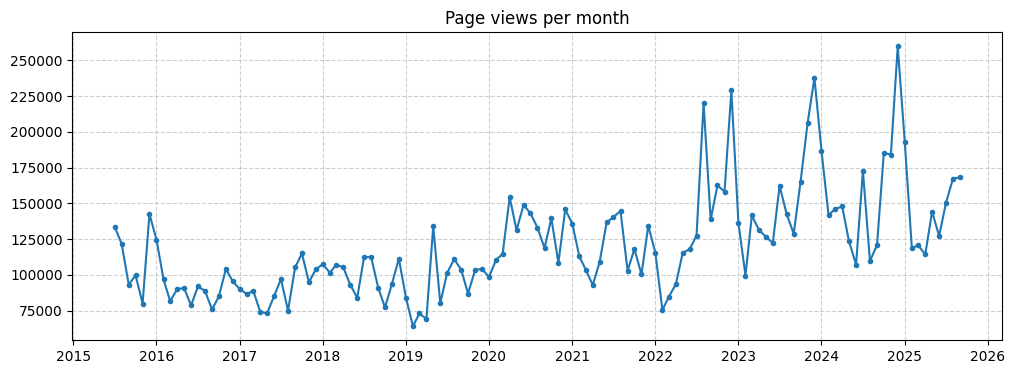

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df["Views"], color="#1f77b4", marker='o', markersize=3)
plt.title("Page views per month")

custom_grid(plt)

plt.show()

***Comment***

*The first thing that catches my eye is a smooth but steady upward trend in the second half of the time series.*

*Seasonality is not yet obvious, but some jumps up before the beginning of the new year (December) and sharp declines after are visible. We can also see some short rises in the middle of the year (more likely July-August).*

*A random component is also present, as indicated by the unevenness of the data in different years and unstable seasonality.*

##### Series decomposition

In [10]:
series = df['Views']
period = 12

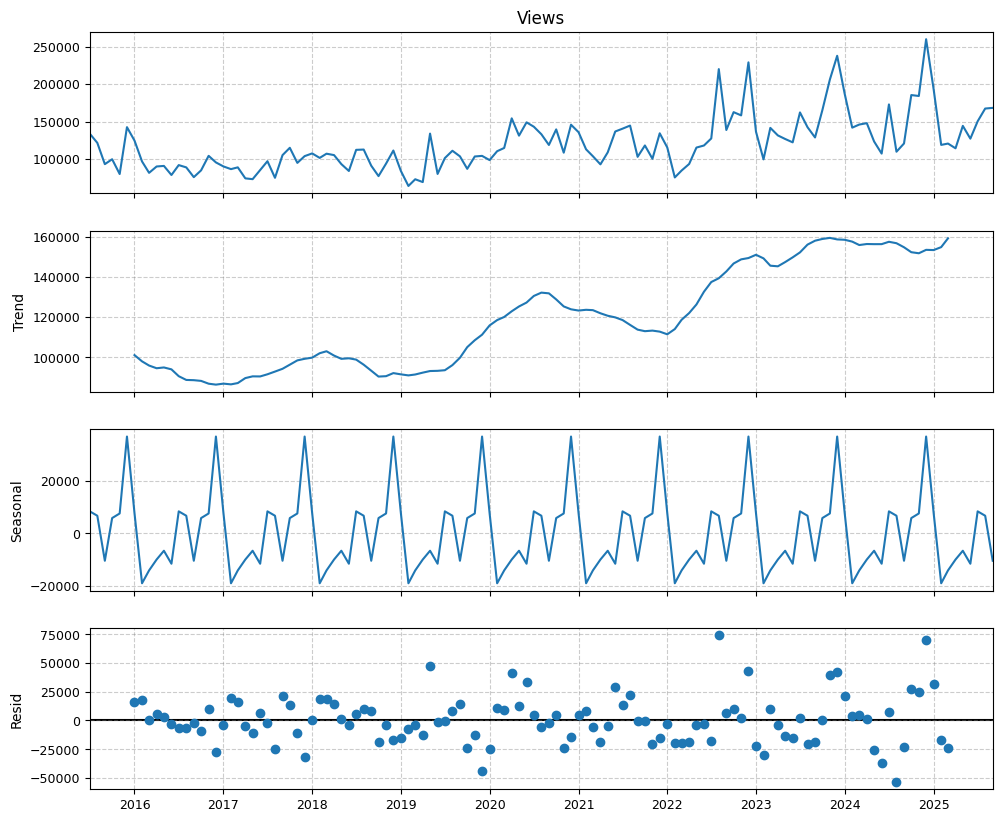

In [11]:
decomposition = seasonal_decompose(series, model='additive', period=period)

fig = decomposition.plot()
fig.set_size_inches(11, 9)

axes = fig.get_axes()
for ax in axes:
    ax.grid(True, linestyle='--', color='gray', alpha=0.4)
    ax.set_facecolor('#ffffff')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

plt.show()

##### Trend function search

In [12]:
trend = decomposition.trend.dropna()
y_trend = trend.values
trend.head(3)

Date
2016-01-01    101013.541667
2016-02-01     97904.208333
2016-03-01     95817.583333
Name: trend, dtype: float64

Polinomial function of 12 degree

In [13]:
x = np.arange(len(df))
y = df['Views'].values

p12 = Polynomial.fit(x, y, deg=12)
y_poly_12 = p12(x)

In [14]:
print("Polynomial equation (Trend fitted function):\n")
print(p12.convert())

Polynomial equation (Trend fitted function):

134491.74999054 - 28205.57653314 x + 8977.77070392 x**2 -
1356.15534047 x**3 + 109.49112809 x**4 - 5.23619578 x**5 +
0.15837183 x**6 - 0.00314226 x**7 + (4.14550573e-05) x**8 -
(3.60254908e-07) x**9 + (1.98114126e-09) x**10 - (6.24848044e-12) x**11 +
(8.61168502e-15) x**12


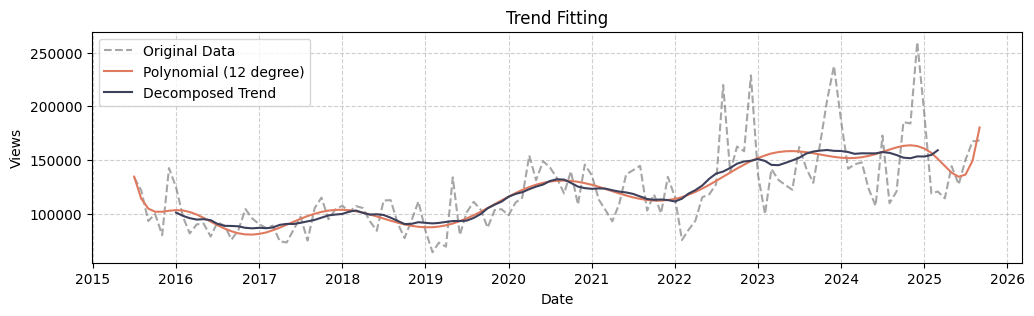

In [15]:
plt.figure(figsize=(12, 3))

plt.plot(df.index, y, color='gray', label='Original Data', linestyle='--', alpha=0.7)
plt.plot(df.index, y_poly_12, label='Polynomial (12 degree)', linewidth=1.5, color="#e07a5f")
plt.plot(trend.index, y_trend, label='Decomposed Trend', linewidth=1.5, color="#3d405b")
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Trend Fitting')

custom_grid(plt)

plt.legend()

plt.show()

##### Build detrended series

In [16]:
detrended = y - y_poly_12 + np.mean(y_poly_12)
detrended_series = pd.Series(detrended, index=df.index)

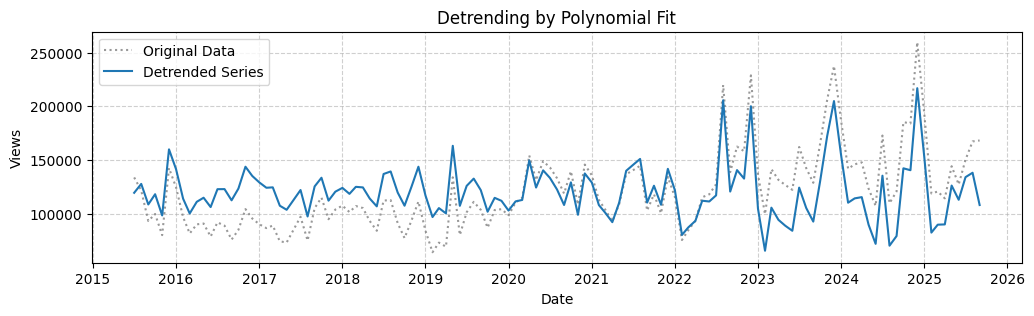

In [17]:
plt.figure(figsize=(12,3))

plt.plot(df.index, y,  color='gray', label='Original Data', linestyle=':', alpha=0.8)
plt.plot(df.index, detrended, label='Detrended Series')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Detrending by Polynomial Fit')

custom_grid(plt)

plt.legend()
plt.show()

##### Exponential smoothing

Single Exponential Smoothing (SES):

bigger alpha -> bigger reaction to new data

In [18]:
alpha = 0.5  
series_smoothed = df['Views'].ewm(alpha=alpha, adjust=False).mean()

Triple Exponential Smoothing (Holt–Winters):

In [19]:
df = df.asfreq('MS')

fit = ExponentialSmoothing(df['Views'], 
                           trend='add', 
                           seasonal='add', 
                           seasonal_periods=12).fit()

y_hat = fit.fittedvalues

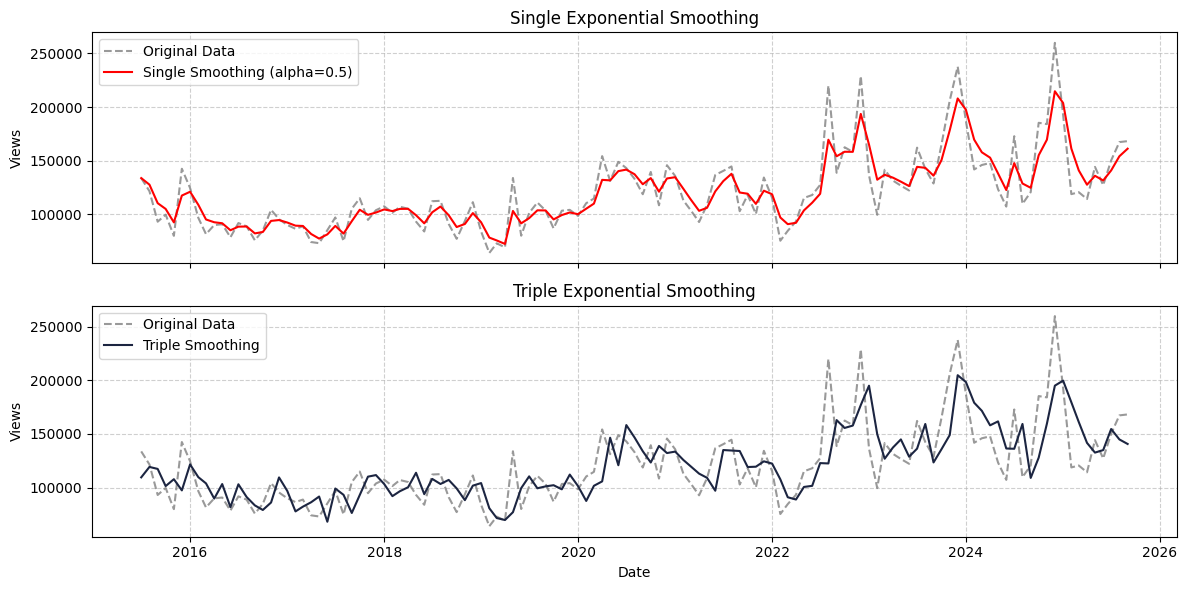

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(df.index, df['Views'], color='gray', label='Original Data', linestyle='--', alpha=0.8)
axes[0].plot(df.index, series_smoothed, label=f'Single Smoothing (alpha={alpha})', color='red')
axes[0].set_title('Single Exponential Smoothing')
axes[0].set_ylabel('Views')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(df.index, df['Views'], color='gray', label='Original Data', linestyle='--', alpha=0.8)
axes[1].plot(df.index, y_hat, label='Triple Smoothing', color='#1c2541')
axes[1].set_title('Triple Exponential Smoothing')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Views')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

##### Hodrick Prescott filter

In [21]:
cycle, trend = sm.tsa.filters.hpfilter(df['Views'], lamb=14400)  

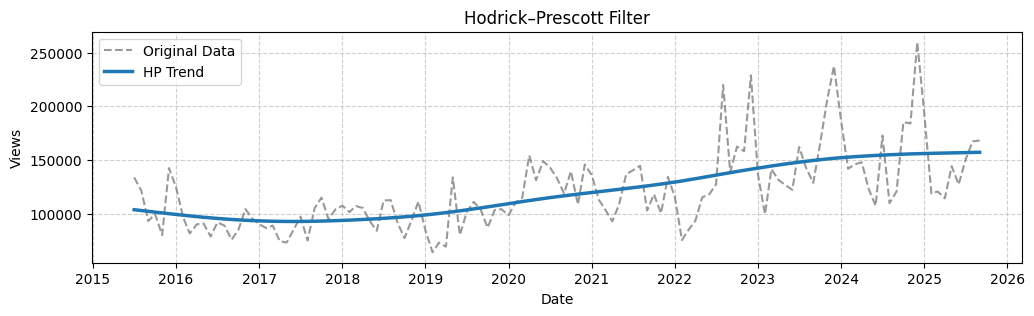

In [22]:
plt.figure(figsize=(12,3))
plt.plot(df.index, df['Views'], color='gray', label='Original Data', linestyle='--', alpha=0.8)
plt.plot(df.index, trend, label='HP Trend',  linewidth=2.5)
plt.title('Hodrick–Prescott Filter')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()

custom_grid(plt)

plt.show()

#### *Conclusion*

*The `decomposition` of the series showed a clear `trend`, which with some cyclicality (every 2-4 years) rises upwards
There is also a clear `seasonality` of the annual length.
The cycle has peaks in the summer (vacations) and before the New Year, which is a quite popular period of time for watching movies
The series also has certain `deviations`. They are quite dense at the beginning, but from the second half of the time series the spread increases noticeably*   

*The 12th degree `polynomial function` is quite similar to the decomposed `trend` via python. However, it has some strange deviation at the end of the time series. I managed to construct a series without a trend by subtracting the found polynomial function.*

*Single and triple `exponential smoothing` were also performed. Since the series has a clear `trend` and `seasonality`, `triple smoothing` is more reliable.*

*`Hodrick Prescott filter` revealed an initial downtrend from 2015 to 2018. However, then we have a steady rise until the end of the series (2025)*

&nbsp;

### 2) Transformation of the series. Stationarity check.

##### Log-transformed series and first differences of the log-transformed series

In [23]:
df['Log_Views'] = np.log(df['Views'])
df['Log_Diff'] = df['Log_Views'].diff()

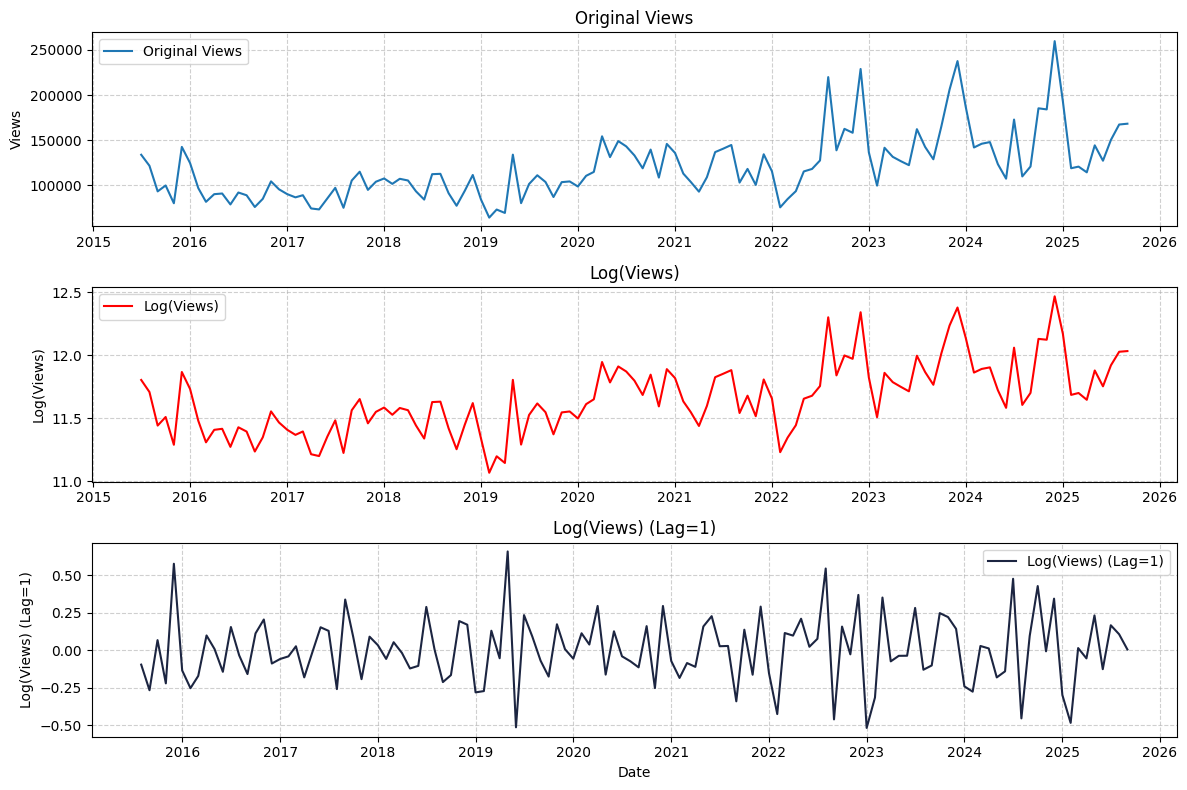

In [24]:
series_list = [
    ('Views', 'Original Views', 'Views', '#1f77b4'),
    ('Log_Views', 'Log(Views)', 'Log(Views)', 'red'),
    ('Log_Diff', 'Log(Views) (Lag=1)', 'Log(Views) (Lag=1)', '#1c2541')
]

plt.figure(figsize=(12, 8))

for i, (col, title, ylabel, color) in enumerate(series_list, 1):
    plt.subplot(3, 1, i)
    plt.plot(df.index, df[col], label=title, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if i == 3:
        plt.xlabel('Date')
    
    custom_grid(plt)
    plt.legend()

plt.tight_layout()
plt.show()

Reminder:

In [25]:
df.head(3)

,Views,Log_Views,Log_Diff
Date,,,
2015-07-01,133772,11.803892,NaN
2015-08-01,121582,11.708344,-0.095548
2015-09-01,93157,11.442042,-0.266303


#### Analysis of the first differences series

#### a) Normality check

Histogram

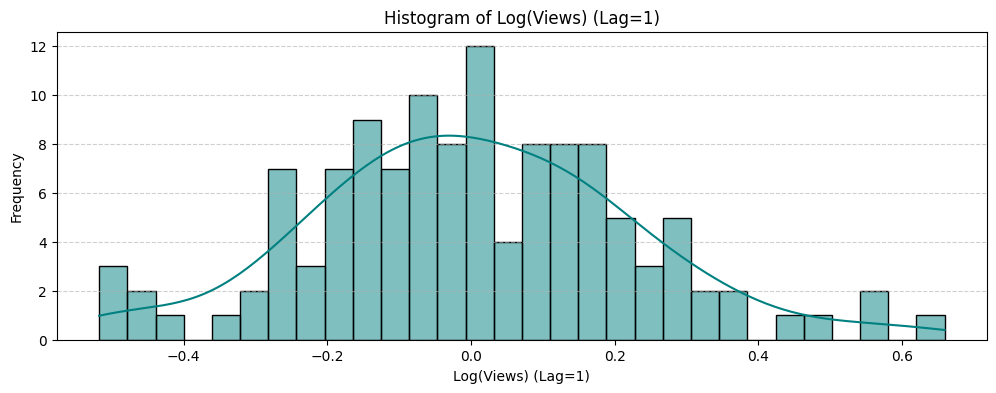

In [26]:
plt.figure(figsize=(12, 4))
sns.histplot(df['Log_Diff'], kde=True, bins=30, color='teal')
plt.title('Histogram of Log(Views) (Lag=1)')
plt.xlabel('Log(Views) (Lag=1)')
plt.ylabel('Frequency')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

Q-Q Plot

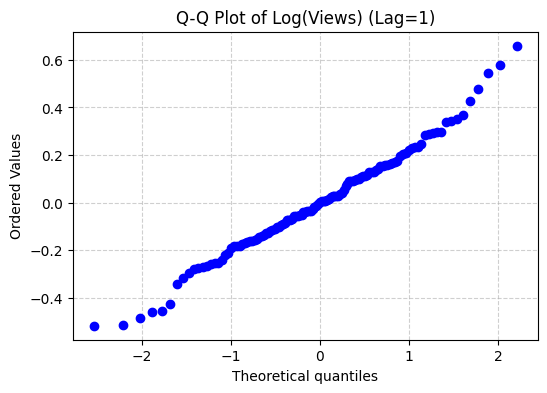

In [27]:
plt.figure(figsize=(6, 4))
stats.probplot(df['Log_Diff'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log(Views) (Lag=1)')

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

##### Statistic normality tests

* H₀: First differences of the log-transformed series are normaly distributed
* H₁: First differences of the log-transformed series are not normaly distributed

Kolmogorov–Smirnov test

In [28]:
log_diff = df['Log_Diff'].dropna()
ks_stat, ks_pvalue = kstest(log_diff, 'norm', args=(log_diff.mean(), log_diff.std()))
print(f"K-S test statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")

K-S test statistic: 0.0419, p-value: 0.9769


Shapiro–Wilk test

In [29]:
sw_stat, sw_pvalue = shapiro(log_diff)
print(f"Shapiro-Wilk test statistic: {sw_stat:.4f}, p-value: {sw_pvalue:.4f}")

Shapiro-Wilk test statistic: 0.9908, p-value: 0.5909


**Comment**: First differences of the log-series are approximately normally distributed, because p-value > 0.05 for both tests.

#### b) Stationarity check

##### Plot splitted series

In [30]:
log_diff = df['Log_Diff'].dropna()
period1 = log_diff['2015':'2021']
period2 = log_diff['2022':'2025']

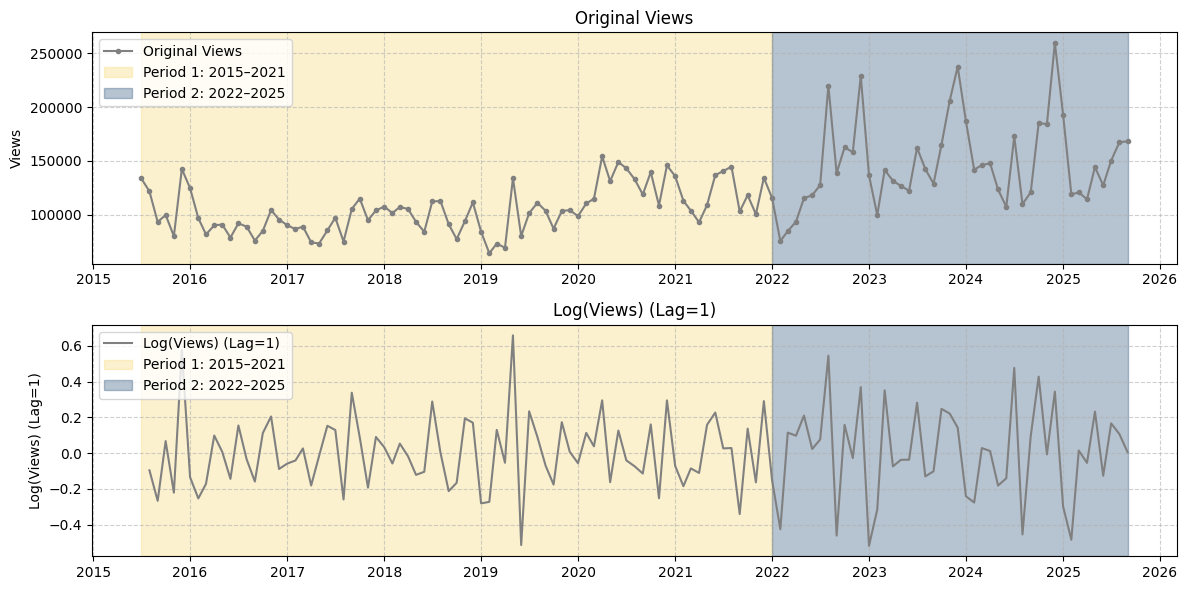

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Views'], label='Original Views', color='gray',  marker='o', markersize=3)
plt.axvspan('2015-07-01', '2021-12-31', color='#f4d35e', alpha=0.3, label='Period 1: 2015–2021')
plt.axvspan('2022-01-01', '2025-09-01', color='#0d3b66', alpha=0.3, label='Period 2: 2022–2025')
plt.title('Original Views')
plt.ylabel('Views')
plt.legend()
custom_grid(plt)

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Log_Diff'], label='Log(Views) (Lag=1)', color='gray')
plt.axvspan('2015-07-01', '2021-12-31', color='#f4d35e', alpha=0.3, label='Period 1: 2015–2021')
plt.axvspan('2022-01-01', '2025-09-01', color='#0d3b66', alpha=0.3, label='Period 2: 2022–2025')
plt.title('Log(Views) (Lag=1)')
plt.ylabel('Log(Views) (Lag=1)')
plt.legend(loc='upper left')
custom_grid(plt)

plt.tight_layout()
plt.show()

##### Analyze two parts of splitted series

Descriptive statistics

In [32]:
def descriptive(series, name):
    print(f"{name} ==================\n")
    print("Mean:", series.mean())
    print("Std:", series.std())
    print("Min:", series.min())
    print("Max:", series.max())
    print("Skewness:", skew(series))
    print("Kurtosis:", kurtosis(series))
    print()

In [33]:
descriptive(period1, "Period 1 (2015–2021)")
descriptive(period2, "Period 2 (2022–2025)")

Period 1 (2015–2021) ==================

Mean: 5.1062327974043296e-05
Std: 0.19930925193299717
Min: -0.5135956775598771
Max: 0.6594005094012267
Skewness: 0.5573154960062001
Kurtosis: 1.0916062498357784

Period 2 (2022–2025) ==================

Mean: 0.00500347624772104
Std: 0.2634528512530594
Min: -0.5175496789596412
Max: 0.5455776137447348
Skewness: -0.13193945407180532
Kurtosis: -0.4903971317808833



##### Statistic stationary test

* H₀: First differences of the log-transformed series are stationary.
* H₁: First differences of the log-transformed series are not stationary.

Dickey-Fuller test

In [34]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"{name} ==================\n")
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("=> Fail to reject H₀: the series is stationary\n")
    else:
        print("=> Reject H₀: the series is non-stationary\n")

In [35]:
print("Dickey-Fuller test\n")

adf_test(period1, "Period 1 (2015–2021)")
adf_test(period2, "Period 2 (2022–2025)")

Dickey-Fuller test

Period 1 (2015–2021) ==================

p-value: 4.272178802105213e-13
=> Fail to reject H₀: the series is stationary

Period 2 (2022–2025) ==================

p-value: 3.705515165693683e-05
=> Fail to reject H₀: the series is stationary



**Comment**: Both parts of the first differences of the log-series are stationary.

#### *Conclusion*

*Series from the `logarithms of the original series` has less pronounced large spikes, so we can talk about some stabilization of the dispersion. The plot itself has a relatively uniform deviation and a smoothly increasing trend, so it is difficult to talk about `stationarity` yet.*

*The `first differences` of the log-series has a fairly clear mean, which is close to zero. There is also no pattern or cyclicality in the plot. And although the plot has some sharp jumps up or down, they are isolated and have no visual connection between them*

*The histogram resembles a normal distribution, as does the Q-Q plot. Also in both `Kolmogorov–Smirnov` and `Shapiro–Wilk` tests have `p-value > 0.05`, so the `first differences` of the log-series are approximately `normally distributed.`*

*I decided to split the series at `2022`, because on the plot these intervals have a significant difference (the second interval has larger deviations). Descriptive statistics confirmed this: `Std = 0.2` for 1 period, `Std = 0.26` for the second. However, the `Dickey-Fuller` test showed that both periods are `stationary` series.*



&nbsp;

Saving dataframe:

In [36]:
df.head(3)

,Views,Log_Views,Log_Diff
Date,,,
2015-07-01,133772,11.803892,NaN
2015-08-01,121582,11.708344,-0.095548
2015-09-01,93157,11.442042,-0.266303


In [37]:
# df.to_csv('page_views_dataframe.csv', index=True)

### 3) Additional research.

#### a) Trend analysis:

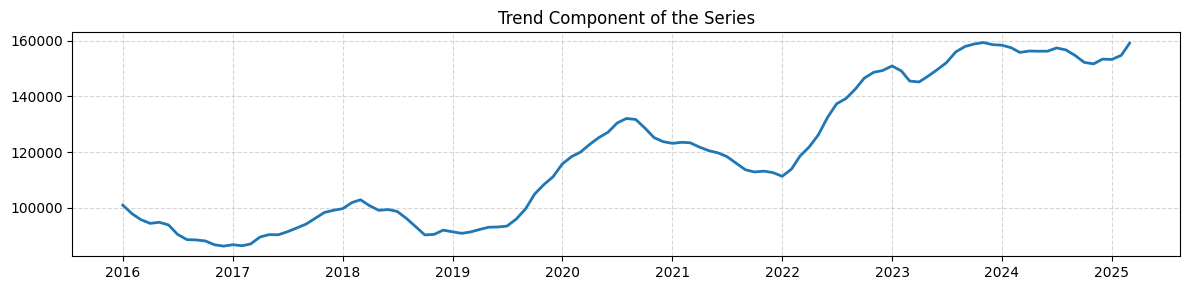

In [126]:
trend = decomposition.trend.dropna()

plt.figure(figsize=(12, 3))
plt.plot(trend.index, trend.values, linewidth=2)
plt.title('Trend Component of the Series')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [67]:
peaks, _ = find_peaks(trend, distance=12, prominence=0.05)

cycle_lengths = trend.index[peaks].to_series().diff().dropna()
cycle_lengths_years = cycle_lengths.dt.days / 365

cycle_info = pd.DataFrame({
    'Peak_Date': trend.index[peaks][1:],  
    'Cycle_Length_Years': cycle_lengths_years.values
})

cycle_info['Cycle_Length_Years'] = cycle_info['Cycle_Length_Years'].round(2)

print("\nTrend Peak detection (skipy):\n")
print(f"\nAverage cycle length: {cycle_lengths_years.mean():.2f} years")
print()
cycle_info


Trend Peak detection (skipy):


Average cycle length: 1.72 years



,Peak_Date,Cycle_Length_Years
0,2018-03-01,1.83
1,2020-08-01,2.42
2,2021-11-01,1.25
3,2023-11-01,2.00
4,2024-12-01,1.08


#### b) Distribution by months:

In [120]:
df['Month'] = df.index.month_name()
df.head(3)

,Views,Log_Views,Log_Diff,Month
Date,,,,
2015-07-01,133772,11.803892,NaN,July
2015-08-01,121582,11.708344,-0.095548,August
2015-09-01,93157,11.442042,-0.266303,September


In [121]:
monthly_views = df.groupby('Month', sort=False)['Views'].mean().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]).reset_index()
monthly_views.head(3)

,Month,Views
0,January,127208.3
1,February,100777.9
2,March,106179.6


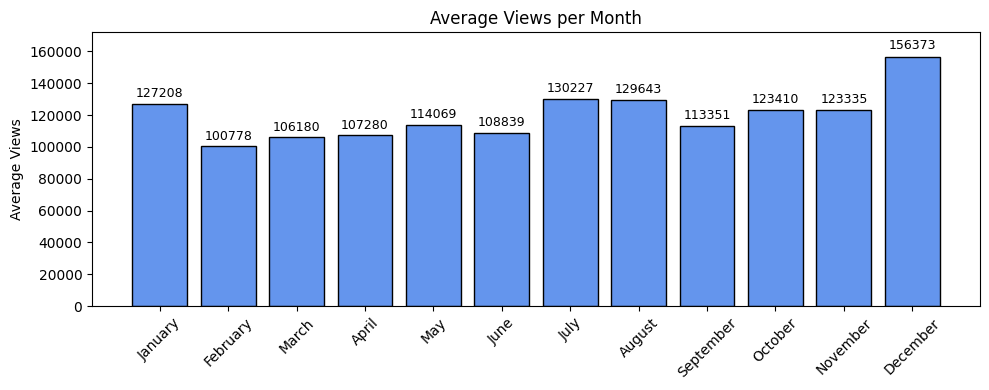

In [122]:
plt.figure(figsize=(10, 4))

bars = plt.bar(monthly_views['Month'], monthly_views['Views'], color='cornflowerblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02*height, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Views per Month')
plt.ylabel('Average Views')

y_max = monthly_views['Views'].max()
plt.ylim(0, y_max * 1.1)

plt.tight_layout()
plt.show()

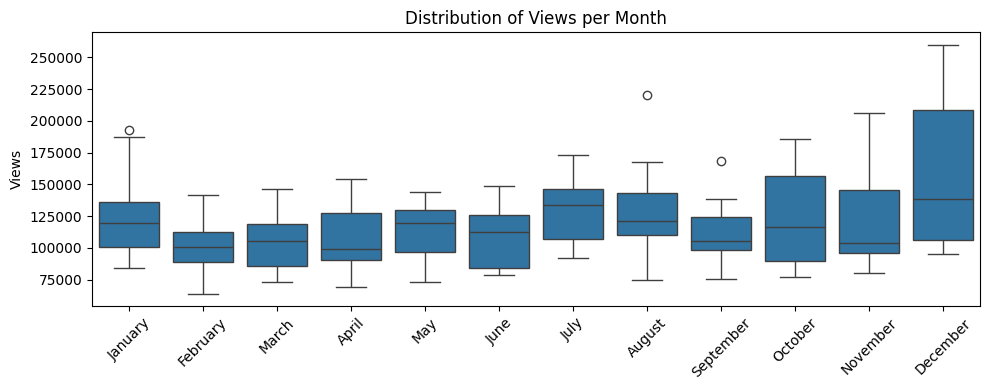

In [129]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='Month', y='Views', data=df,
            order=['January','February','March','April','May','June',
                   'July','August','September','October','November','December'])
plt.xticks(rotation=45)
plt.title('Distribution of Views per Month')
plt.xlabel('') 

plt.tight_layout()
plt.show()

#### *Conclusion*

*I used the built-in function `find_peaks` from `skipy` to find the peak points of the series. In total, 3 out of 5 `peaks` found belong to the pre-New Year period, and this trend continues after 22 years. Also, the built-in function determined the average `cycle` at `1.72`, which actually depends on the given parameters and gives little information.*

*Regarding the analysis of `views by month`, there is a predicted increased interest in the film in the winter months `(December, January)` and summer months `(July, August)`. In addition, after increased values, views have a sharp decline in `February`.*

*In addition, the `boxplot` showed very high volatility precisely in the months with increased views. This indicates that increased views in these months are not guaranteed. Most likely, the increase in views before the New Year in the second half of the summer has not only a `seasonal factor`, but also some other `unknown reasons` (for example, in some years the popularity of the actors who played in this film (Tom Cruise and Nicole Kidman) may increase, which increased the views of the film itself).*


&nbsp;